# Model predictions - Colizoli, de Gee, Urai & Donner

#### Import necessary packages from Python

In [24]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

#### Set parameters for plotting

In [25]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set(style='ticks', font='Arial', font_scale=1, rc={
    'axes.linewidth': 1,
    'axes.labelsize': 7, 
    'axes.titlesize': 7,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'text.color': 'Black',
    'axes.labelcolor':'Black',
    'xtick.color':'Black',
    'ytick.color':'Black',} )
sns.plotting_context()

{'axes.labelsize': 7.0,
 'axes.titlesize': 7.0,
 'figure.figsize': [8.0, 5.5],
 'font.size': 12.0,
 'grid.linewidth': 1.0,
 'legend.fontsize': 6.0,
 'lines.linewidth': 1.75,
 'lines.markeredgewidth': 0.0,
 'lines.markersize': 7.0,
 'patch.linewidth': 0.3,
 'xtick.labelsize': 6.0,
 'xtick.major.pad': 7.0,
 'xtick.major.width': 1.0,
 'xtick.minor.width': 0.5,
 'ytick.labelsize': 6.0,
 'ytick.major.pad': 7.0,
 'ytick.major.width': 1.0,
 'ytick.minor.width': 0.5}

## Signal Detection Theory - competing model predictions

#### Sigma is the noise in the data

In [26]:
# see Estimate Sigma in this repository
sigma = 1/7.5 

#### Generate 'stimuli' - values of motion coherence moving either up or down [1 or -1]

In [27]:
model_coh = np.arange(-.5,.5,0.01) # extreme values of motion coherence, 1=100% coherent motion      
model_evs = np.repeat(model_coh, 10000) # repeat each coherence value 10000 times

#### The internal decision variable, dv, is a 'noisy' version of the stimuli

In [28]:
model_dvs = model_evs + np.random.normal(0, sigma, len(model_evs)) # add noise to the decision variable

#### The choice on each trial is the sign of the noisy decision variable

In [29]:
model_choice = np.sign(model_dvs) # the choice is the sign of the dv, up or down
model_correct = model_choice == np.sign(model_evs) # correct choice when sign dv = sign of ev

#### Equation 3 transforms the dv to the probability of a correct response based on the noise in the data

In [30]:
def dv2conf(x,sigma):
    from scipy.special import erf
    return 0.5 * (1 + erf(x / (np.sqrt(2)*sigma)))

#### The difference in the two models is here: whether confidence is a function of the external or internal decision variable (Equation 1 vs. Equation 2)

In [31]:
c = 0 # criterion set to 0, assuming no bias
model_confidence_belief = dv2conf(np.abs(model_dvs-c),sigma); # belief state model (model1)
model_confidence = dv2conf(np.abs(model_evs-c),sigma); # stimulus state model (model2)
# see cell 'Averaging' for n trials for each conditions

#### Define the feedback and prediction error for each model

In [32]:
model_feedback = model_correct; # feedback = 0 or 1
model_rpe_belief = model_feedback - model_confidence_belief; # belief state model, see Eq. 5 and cell 'Averaging'
model_rpe = model_feedback - model_confidence; # stimulus state model, see Eq. 5 and cell 'Averaging'

#### Save model predictions

In [33]:
model_levels_dvs = np.abs(model_dvs) # collapse across up/down directions, because difficulty is orthogonal to direction

model1 = pd.DataFrame() # belief state model
model1['evs'] = model_evs
model1['dvs'] = model_dvs
model1['ev_levels'] = np.abs(model_evs) 
model1['correct'] = model_correct
model1['confidence'] = model_confidence_belief
model1['uncertainty'] = 1 - model_confidence_belief
model1['pe'] = model_rpe_belief
model1['pe_inv'] = 1 - model_rpe_belief 

model2 = pd.DataFrame() # stimulus state model
model2['evs'] = model_evs
model2['dvs'] = model_dvs
model2['ev_levels'] = np.abs(model_evs) 
model2['correct'] = model_correct
model2['confidence'] = model_confidence 
model2['uncertainty'] = 1 - model_confidence
model2['pe'] = model_rpe  
model2['pe_inv'] = 1 - model_rpe 

# model1.to_csv('model1.csv') # uncomment to save model predictions as CSV files
# model2.to_csv('model2.csv')

## Plot model predictions

#### Plotting in the direction of uncertainty

In [34]:
# UNCERTAINTY
decision_dv = 'uncertainty'
feedback_dv = 'pe_inv'
# y lims
dec = [0,0.5]
feed = [0.4,2]
inter = [-0.5,0.5]
yticksfeed = [0.4,0.8,1.2,1.6,2]
# xlims
xdiff = [0,0.5]
xdifflabels = ['Hard','Easy']

#### Set number of bins

In [35]:
nbins = 10
bin_labels = range(1,nbins+1)

#### Averaging: group predictions by stimulus/coherence levels and accuracy

In [36]:
# averaging over n in Eq.1 and Eq.2, 
# where n is the number of trials in each ev_level separately for error and correct responses
m1_dec = model1.groupby(['ev_levels','correct'])[decision_dv].mean()
m2_dec = model2.groupby(['ev_levels','correct'])[decision_dv].mean()

m1_feed = model1.groupby(['ev_levels','correct'])[feedback_dv].mean()
m2_feed = model2.groupby(['ev_levels','correct'])[feedback_dv].mean()

m1_dec = m1_dec.reset_index() # resets indices to accessible columns
m2_dec = m2_dec.reset_index()
m1_feed = m1_feed.reset_index()
m2_feed = m2_feed.reset_index()

### Plotting

#### Define a figure (2 x 3 panels)

<IPython.core.display.Javascript object>


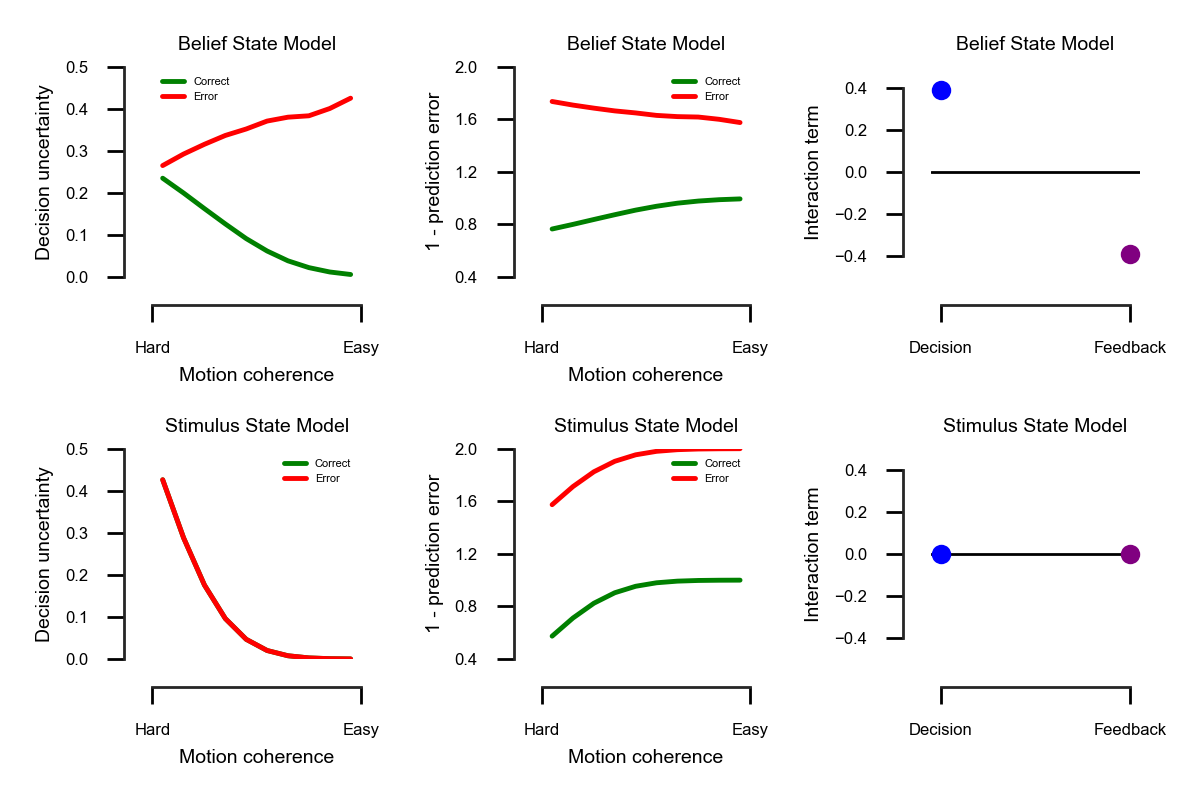

In [37]:
fig = plt.figure(figsize=(6,4))
        
# for interaction plots
ind = [0.3,0.5]
xlim = [0.275,0.575]

# get xlabels and color scheme for two conditions
ls = 'interact' # corresponding to lines
leg_label = ['Decision','Feedback']
colors = ['blue','purple']
alphas = [1,1]
xticklabels = ['Decision','Feedback'] # for interaction

#### Belief State Model - Decision interval (subplot 1)

In [38]:
ax = fig.add_subplot(231)
        
# Make equal size bins for the error trials (correct==False)
# Average coherence and confidence in each bin
valuelist = [False]
F = m1_dec[m1_dec.correct.isin(valuelist)] # ev_levels that have errors
valueList = np.array(F['ev_levels'])
T =  m1_dec[m1_dec['correct']] # only true values
T = T[T.ev_levels.isin(valueList)] # get only those ev_levels that are in m1_dec_F

F = F.reset_index() 
T = T.reset_index() 

# Error
bins_F = pd.qcut(F['ev_levels'], nbins, labels=bin_labels, retbins=True) 
F['bins'] = np.array(bins_F[0]) # tupel, get first element out
F_binned = F.groupby(['bins'])['ev_levels', decision_dv].mean()

# Correct
bins_T = pd.qcut(T['ev_levels'], nbins, labels=bin_labels, retbins=True) 
T['bins'] = np.array(bins_T[0]) # tupel, get first element out
T_binned = T.groupby(['bins'])['ev_levels', decision_dv].mean()

# Save for interaction plot
easy_error_dec = F_binned.iloc[-1,-1] # last level, confidence/pe
hard_error_dec = F_binned.iloc[0,-1] # first level, confidence/pe
easy_correct_dec = T_binned.iloc[-1,-1] # last level, confidence/pe
hard_correct_dec = T_binned.iloc[0,-1] # first level, confidence/pe

### LINE GRAPH ###        
ax.plot(T_binned['ev_levels'],T_binned[decision_dv], label='Correct', color='green', alpha=1)
ax.plot(F_binned['ev_levels'],F_binned[decision_dv], label='Error', color='red', alpha=1)

# Subplot parameters
ax.set_ylim(dec)
ax.set_xticks(xdiff)
ax.set_xticklabels(xdifflabels)
ax.legend(loc='best', fontsize=4)
ax.set_ylabel('Decision uncertainty')
ax.set_xlabel('Motion coherence')
ax.set_title('Belief State Model')


#### Belief State Model - Feedback interval (subplot 2)

In [39]:
ax = fig.add_subplot(232)

# Make equal size bins for the error trials (correct==False)
# Average coherence and confidence in each bin
valuelist = [False]
F = m1_feed[m1_feed.correct.isin(valuelist)] # ev_levels that have errors
valueList = np.array(F['ev_levels'])
T =  m1_feed[m1_feed['correct']] # only true values
T = T[T.ev_levels.isin(valueList)] # get only those ev_levels that are in m1_dec_F

F = F.reset_index() 
T = T.reset_index() 

# Error
bins_F = pd.qcut(F['ev_levels'], nbins, labels=bin_labels, retbins=True) 
F['bins'] = np.array(bins_F[0]) # tupel, get first element out
F_binned = F.groupby(['bins'])['ev_levels', feedback_dv].mean()

# Correct
bins_T = pd.qcut(T['ev_levels'], nbins, labels=bin_labels, retbins=True) 
T['bins'] = np.array(bins_T[0]) # tupel, get first element out
T_binned = T.groupby(['bins'])['ev_levels', feedback_dv].mean()

# save for interaction plot
easy_error_feed = F_binned.iloc[-1,-1] # last level, confidence/pe
hard_error_feed = F_binned.iloc[0,-1] # first level, confidence/pe
easy_correct_feed = T_binned.iloc[-1,-1] # last level, confidence/pe
hard_correct_feed = T_binned.iloc[0,-1] # first level, confidence/pe

### LINE GRAPH ###        
ax.plot(T_binned['ev_levels'],T_binned[feedback_dv], label='Correct', color='green', alpha=1)
ax.plot(F_binned['ev_levels'],F_binned[feedback_dv], label='Error', color='red', alpha=1)

# Subplot parameters
ax.set_xticks(xdiff)
ax.set_ylim(feed)
ax.set_yticks(yticksfeed)
ax.set_xticklabels(xdifflabels)
ax.legend(loc='best', fontsize=4)
ax.set_ylabel('1 - prediction error')
ax.set_xlabel('Motion coherence')
ax.set_title('Belief State Model')

#### Belief State Model - Interaction (subplot 3)

In [40]:
ax = fig.add_subplot(233)
ax.axhline(0, lw=1, alpha=1, color = 'k') # Add horizontal line at t=0    

easy_error_dec = np.round(easy_error_dec,2) # round to 2 decimal places
hard_error_dec = np.round(hard_error_dec,2)
easy_correct_dec = np.round(easy_correct_dec,2)
hard_correct_dec = np.round(hard_correct_dec,2)

easy_error_feed = np.round(easy_error_feed,2)
hard_error_feed = np.round(hard_error_feed,2)
easy_correct_feed = np.round(easy_correct_feed,2)
hard_correct_feed = np.round(hard_correct_feed,2)

interaction_decision = (easy_error_dec - easy_correct_dec) - (hard_error_dec - hard_correct_dec)
interaction_feed = (easy_error_feed - easy_correct_feed) - (hard_error_feed - hard_correct_feed)

MEANS = [interaction_decision,interaction_feed]

for x,m in enumerate(MEANS):
    ax.plot(ind[x],MEANS[x], marker='o', color=colors[x], label=leg_label[x], alpha=alphas[x])

# Subplot parameters
ax.set_xticks(ind)
ax.set_ylim(inter)
ax.set_xticklabels(xticklabels)
ax.legend([])
ax.set_ylabel('Interaction term')
ax.set_title('Belief State Model')

#### Stimulus State Model - Decision interval (subplot 4)

In [41]:
ax = fig.add_subplot(234)

# Make equal size bins for the error trials (correct==False)
# Average coherence and confidence in each bin
valuelist = [False]
F = m2_dec[m2_dec.correct.isin(valuelist)] # ev_levels that have errors
valueList = np.array(F['ev_levels'])
T =  m2_dec[m2_dec['correct']] # only true values
T = T[T.ev_levels.isin(valueList)] # get only those ev_levels that are in m1_dec_F

F = F.reset_index() 
T = T.reset_index() 

# Error
bins_F = pd.qcut(F['ev_levels'], nbins, labels=bin_labels, retbins=True) 
F['bins'] = np.array(bins_F[0]) # tupel, get first element out
F_binned = F.groupby(['bins'])['ev_levels', decision_dv].mean()

# Correct
bins_T = pd.qcut(T['ev_levels'], nbins, labels=bin_labels, retbins=True) 
T['bins'] = np.array(bins_T[0]) # tupel, get first element out
T_binned = T.groupby(['bins'])['ev_levels', decision_dv].mean()

# Save for interaction plot
easy_error_dec = F_binned.iloc[-1,-1] # last level, confidence/pe
hard_error_dec = F_binned.iloc[0,-1] # first level, confidence/pe
easy_correct_dec = T_binned.iloc[-1,-1] # last level, confidence/pe
hard_correct_dec = T_binned.iloc[0,-1] # first level, confidence/pe

### LINE GRAPH ###        
ax.plot(T_binned['ev_levels'],T_binned[decision_dv], label='Correct', color='green', alpha=1)
ax.plot(F_binned['ev_levels'],F_binned[decision_dv], label='Error', color='red', alpha=1)

# Subplot parameters
ax.set_xticks(xdiff)
ax.set_ylim(dec)
ax.set_xticklabels(xdifflabels)
ax.legend(loc='best', fontsize=4)
ax.set_ylabel('Decision uncertainty')
ax.set_xlabel('Motion coherence')
ax.set_title('Stimulus State Model')

#### Stimulus State Model - Feedback interval (subplot 5)

In [42]:
ax = fig.add_subplot(235)

# Make equal size bins for the error trials (correct==False)
# Average coherence and confidence in each bin
valuelist = [False]
F = m2_feed[m2_feed.correct.isin(valuelist)] # ev_levels that have errors
valueList = np.array(F['ev_levels'])
T =  m2_feed[m2_feed['correct']] # only true values
T = T[T.ev_levels.isin(valueList)] # get only those ev_levels that are in m1_dec_F

F = F.reset_index() 
T = T.reset_index() 

# Error
bins_F = pd.qcut(F['ev_levels'], nbins, labels=bin_labels, retbins=True) 
F['bins'] = np.array(bins_F[0]) # tupel, get first element out
F_binned = F.groupby(['bins'])['ev_levels', feedback_dv].mean()

# Correct
bins_T = pd.qcut(T['ev_levels'], nbins, labels=bin_labels, retbins=True) 
T['bins'] = np.array(bins_T[0]) # tupel, get first element out
T_binned = T.groupby(['bins'])['ev_levels', feedback_dv].mean()

# Save for interaction plot
easy_error_feed = F_binned.iloc[-1,-1] # last level, confidence/pe
hard_error_feed = F_binned.iloc[0,-1] # first level, confidence/pe
easy_correct_feed = T_binned.iloc[-1,-1] # last level, confidence/pe
hard_correct_feed = T_binned.iloc[0,-1] # first level, confidence/pe

### LINE GRAPH ###        
ax.plot(T_binned['ev_levels'],T_binned[feedback_dv], label='Correct', color='green', alpha=1)
ax.plot(F_binned['ev_levels'],F_binned[feedback_dv], label='Error', color='red', alpha=1)

# Subplot parameters
ax.set_xticks(xdiff)
ax.set_ylim(feed)
ax.set_yticks(yticksfeed)
ax.set_xticklabels(xdifflabels)
ax.legend(loc='best', fontsize=4)
ax.set_ylabel('1 - prediction error')
ax.set_xlabel('Motion coherence')
ax.set_title('Stimulus State Model')

#### Stimulus State Model - Interaction (subplot 6)

In [43]:
ax = fig.add_subplot(236)
ax.axhline(0, lw=1, alpha=1, color = 'k') # Add horizontal line at t=0

easy_error_dec = np.round(easy_error_dec,2)
hard_error_dec = np.round(hard_error_dec,2)
easy_correct_dec = np.round(easy_correct_dec,2)
hard_correct_dec = np.round(hard_correct_dec,2)

easy_error_feed = np.round(easy_error_feed,2)
hard_error_feed = np.round(hard_error_feed,2)
easy_correct_feed = np.round(easy_correct_feed,2)
hard_correct_feed = np.round(hard_correct_feed,2)

interaction_decision = (easy_error_dec - easy_correct_dec) - (hard_error_dec - hard_correct_dec)
interaction_feed = (easy_error_feed - easy_correct_feed) - (hard_error_feed - hard_correct_feed)

MEANS = [interaction_decision,interaction_feed]

for x,m in enumerate(MEANS):
    ax.plot(ind[x],MEANS[x], marker='o', color=colors[x], label=leg_label[x], alpha=alphas[x])

# Subplot parameters
ax.set_xticks(ind)
ax.set_ylim(inter)
ax.set_xticklabels(xticklabels)
ax.legend([])
ax.set_ylabel('Interaction term')
ax.set_title('Stimulus State Model')


### Competing Model Predictions

In [44]:
plt.show()

#### Save figure

In [45]:
sns.despine(offset=10, trim=True)
plt.tight_layout()
# fig.savefig('model_predictions.pdf')